# Lightning climatology
1. since beginning of GLM to near-present
2. restricted to DNN training and testing times
    * GLM
    * Weather Bug
        * flashes per time window (1, 2, or 4 hours)
        * base rate of over *t* flashes per time window

In [1]:
import datetime
import logging
import os
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray
from matplotlib.colors import BoundaryNorm, ListedColormap

%matplotlib inline
from metpy.units import units

# for ratio plots
from scipy.ndimage import gaussian_filter

import G211
import lightning
from ml_functions import get_args, get_glm
from statisticplot import ax_features, make_map

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(message)s")

2024-08-13 10:59:23.272857: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 10:59:25.750824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rptdist = 20
twin = 1
o_thresh = 1
var = f"flashes_{rptdist}km_{twin}hr"

tmpdir = Path(os.getenv("TMPDIR"))

In [3]:
G211.x2().mask.sum()

<xarray.DataArray ()>
array(5207)

In [4]:
# map projection
map_crs = G211.g211
makemapkw = dict(projection=map_crs, scale=1.3)
cmap = lightning.cmap
n = 23 if rptdist == 40 else 10
norm = BoundaryNorm(range(n), ncolors=cmap.N, clip=True)
dpi = 200

### GLM average count per time window starting at beginning of GLM (20180213T17)

2024-08-13 11:01:04,604 made /glade/campaign/mmm/parc/ahijevyc/GLM/longterm_average.glm_20km_1hr.png


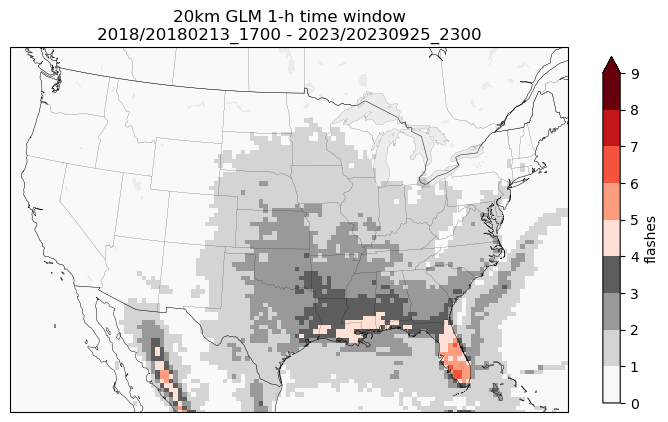

In [5]:
GLMnc = f"GLM/longterm_average.glm_{rptdist}km_{twin}hr.nc"
GLM_longterm_average = xarray.open_dataset(GLMnc)
# history attribute contains the NCO command that created this netCDF file
# The NCO command contains a list of files that went into this file.
ifiles = sorted(GLM_longterm_average.attrs["nco_input_file_list"].split())

time_range = " - ".join([ifiles[0][:18], ifiles[-1][:18]])
glm_tmin = datetime.datetime.strptime(min(ifiles)[5:18], "%Y%m%d_%H%M")
glm_tmax = datetime.datetime.strptime(max(ifiles)[5:18], "%Y%m%d_%H%M")

fig, ax = make_map(**makemapkw)
sc = GLM_longterm_average["flashes"].plot(
    x="lon",
    y="lat",
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    ax=ax,
    norm=norm,
    cbar_kwargs={"shrink": 0.75},
)
ax.set_title(f"{rptdist}km GLM {twin}-h time window\n{time_range}")
base, ext = os.path.splitext(GLMnc)
ofile = os.path.realpath(base + ".png")
fig.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")
del GLM_longterm_average.attrs["nco_input_file_list"]

In [6]:
wxbugnc = f"wbug_lightning/flash.{rptdist}km_30min.nc"
logging.info(f"open ENTLN {wxbugnc}")
wb = xarray.open_dataset(wxbugnc)

dt = wb.time_coverage_start.diff(dim="time_coverage_start").median()
assert dt.dt.seconds == 1800

# Should match ml_functions.load_df()
# mean of 30-minute lightning blocks in time window, times twin * 2
# Renaming time_coverage_start -> valid_time results in 
# a centered time window. .rolling assumes time window already happened
logging.info(f"sum weatherbug {rptdist}km flashes in {twin}hr time window")

wb_cnt = (
    wb.resample(time_coverage_start="30min")
    .first()
    .rolling(
        dim={"time_coverage_start": twin * 2},
        min_periods=twin,
        center=True,
    )
    .mean()
    .rename({"time_coverage_start": "valid_time"})
    * twin
    * 2
)

2024-08-13 11:10:27,328 open ENTLN wbug_lightning/flash.20km_30min.nc
2024-08-13 11:10:27,722 sum weatherbug 20km flashes in 1hr time window


2024-08-13 11:41:58,813 average 97214 times 20180213 17:00 - 20230831 23:30
2024-08-13 11:42:24,204 done
2024-08-13 11:42:26,060 made GLM/longterm_average.glm_20km_1hr.png


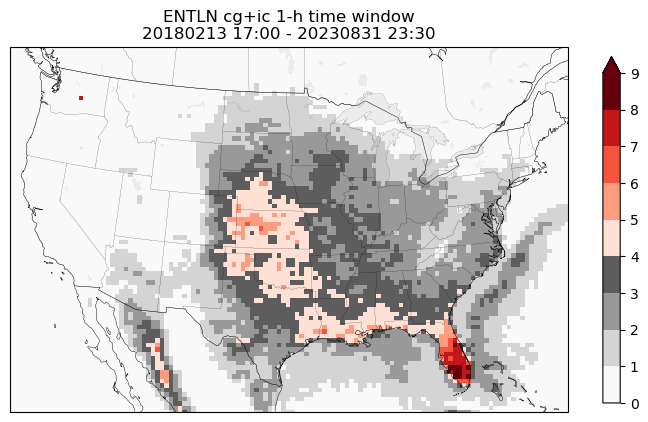

In [7]:
wb_cnt_slice = wb_cnt.sel(
    valid_time=slice(glm_tmin, glm_tmax)
)  # same time slice as GLM
fmt = "%Y%m%d %H:%M"
twin_str = f"{wb_cnt_slice.valid_time.min().dt.strftime(fmt).data} - {wb_cnt_slice.valid_time.max().dt.strftime(fmt).data}"

logging.info(f"average {wb_cnt_slice.valid_time.size} times {twin_str}")
wb_mean = wb_cnt_slice.mean(dim="valid_time")
logging.info("done")

fig, ax = make_map(**makemapkw)
sc = (wb_mean.cg + wb_mean.ic).plot(
    x="lon",
    y="lat",
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    norm=norm,
    cbar_kwargs={"shrink": 0.75},
)
ax.set_title(f"ENTLN cg+ic {twin}-h time window\n{twin_str}")

base, ext = os.path.splitext(GLMnc)
ofile = f"{base}.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")

In [8]:
def ratio_plot(r, ax=None):
    r = r.metpy.convert_units("%")
    levels = [10, 50, 75, 90, 110, 133, 200, 1000]
    sigma = 2.5
    if ax is None:
        fig, ax = make_map(**makemapkw)
    CS = r.plot(
        x="lon",
        y="lat",
        transform=ccrs.PlateCarree(),
        ax=ax,
        norm=colors.LogNorm(vmin=min(levels), vmax=max(levels)),
        cmap="RdBu_r",
        cbar_kwargs={"shrink": 0.9},
    )
    r.data = gaussian_filter(r.data, sigma)
    CS = r.plot.contour(
        x="lon",
        y="lat",
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors="0.2",
        ax=ax,
    )
    ax.clabel(CS)
    return ax

In [9]:
def diff_plot(r, ax=None):
    r = r.metpy.convert_units("%")
    levels = [-1, -0.5, 0, 0.5, 1]
    sigma = 2.5
    if ax is None:
        fig, ax = make_map(**makemapkw)
    CS = r.plot(
        x="lon",
        y="lat",
        transform=ccrs.PlateCarree(),
        ax=ax,
        norm=colors.Normalize(vmin=min(levels), vmax=max(levels)),
        cmap="RdBu_r",
        cbar_kwargs={"shrink": 0.9},
    )
    r.data = gaussian_filter(r.data, sigma)
    CS = r.where(G211.x2().mask).plot.contour(
        x="lon",
        y="lat",
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors="0.2",
        ax=ax,
    )
    ax.clabel(CS)
    return ax

In [10]:
# assert lon and lat are only slightly different (< 1e-13)
# and assign one to the other
assert np.isclose(GLM_longterm_average.lon, wb_mean.lon).all()
GLM_longterm_average = GLM_longterm_average.assign_coords(lon = wb_mean["lon"])
assert np.isclose(GLM_longterm_average.lat, wb_mean.lat).all()
GLM_longterm_average = GLM_longterm_average.assign_coords(lat = wb_mean["lat"])

In [11]:
wb_mean

<xarray.Dataset>
Dimensions:  (y: 129, x: 185)
Coordinates:
    lon      (y, x) float64 -133.5 -133.1 -132.8 -132.4 ... -50.44 -49.91 -49.39
    lat      (y, x) float64 12.19 12.29 12.39 12.49 ... 57.58 57.49 57.39 57.29
Dimensions without coordinates: y, x
Data variables:
    cg       (y, x) float64 0.00283 0.001426 0.002593 ... 2.161e-05 0.0 0.0
    ic       (y, x) float64 0.0006698 0.0002809 0.000713 0.00108 ... 0.0 0.0 0.0

2024-08-13 12:47:45,750 made GLM/longterm_average.glm_20km_1hr.GLMWxBugratio.png


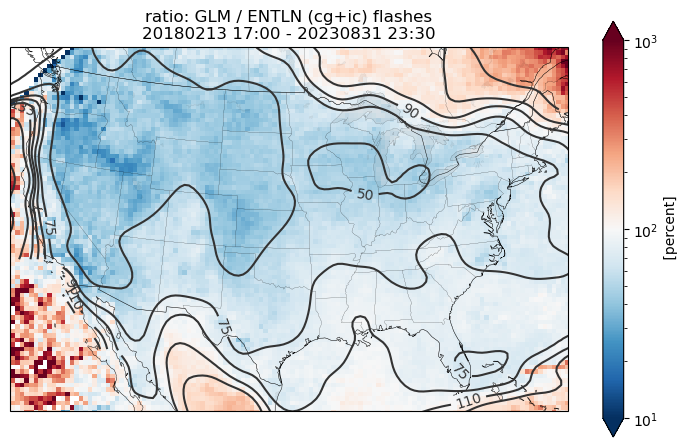

In [12]:
# squeeze to rid 1-element time dimension
r = GLM_longterm_average.flashes.squeeze() / (wb_mean.cg + wb_mean.ic)
ax = ratio_plot(r)
ax.set_title(f"ratio: GLM / ENTLN (cg+ic) flashes\n{twin_str}")
ofile = base + ".GLMWxBugratio.png"
ax.figure.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")

2024-08-13 12:47:46,699 made GLM/longterm_average.glm_20km_1hr.GLMICratio.png


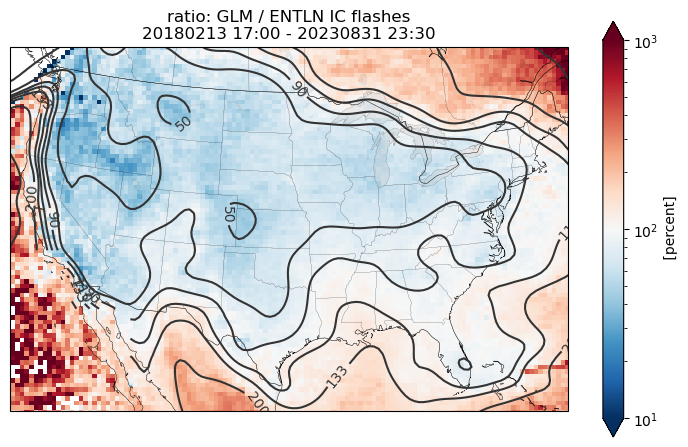

In [13]:
r = GLM_longterm_average.flashes.squeeze() / wb_mean.ic
ax = ratio_plot(r)
ax.set_title(f"ratio: GLM / ENTLN IC flashes\n{twin_str}")
ofile = base + ".GLMICratio.png"
ax.figure.savefig(ofile, dpi=dpi)
logging.warning(f"made {ofile}")

## Same time range as DNN train and test

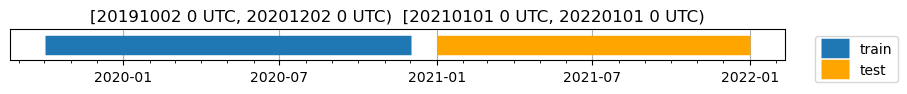

In [14]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

args = get_args(o_thresh, twin)
fig, ax = plt.subplots(figsize=(10, 0.4))
ax.plot()
# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.yaxis.set_major_locator(ticker.NullLocator())
lw = 14
ax.hlines(0, args.trainstart, args.trainend, label="train", lw=lw)
ax.hlines(0, args.teststart, args.testend, label="test", color="orange", lw=lw)
ax.legend(loc="upper left", bbox_to_anchor=(1.03, 1.0))
ax.set_title(
    f"[{args.trainstart:%Y%m%d %-H UTC}, {args.trainend:%Y%m%d %-H UTC})  [{args.teststart:%Y%m%d %-H UTC}, {args.testend:%Y%m%d %-H UTC})"
)
ax.grid()

In [15]:
time_space_window = (twin, rptdist)
glm_twin = get_glm(time_space_window, start=args.trainstart, end=args.testend - pd.Timedelta(minutes=30))

2024-08-13 12:47:47,501 get_glm: time/space window 1/20 start=2019-10-02 00:00:00 end=2021-12-31 23:30:00
2024-08-13 12:47:47,564 open /glade/derecho/scratch/ahijevyc/tmp/all.glm_20km_1hr.nc for GLM flashes
2024-08-13 12:47:48,390 trim GLM to slice(Timestamp('2019-10-02 00:00:00'), Timestamp('2021-12-31 23:30:00'), None)
2024-08-13 12:47:48,427 Store in new DataArray flashes_20km_1hr


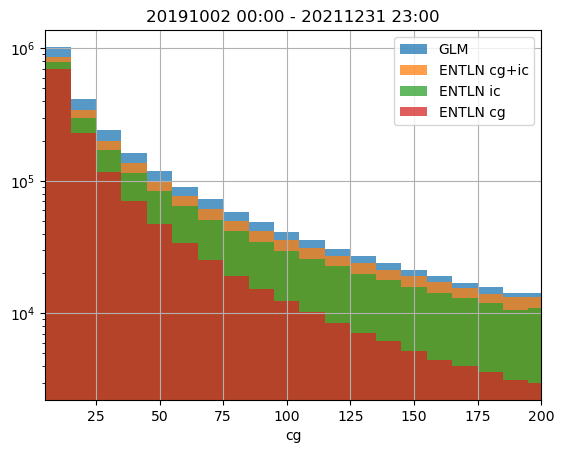

In [16]:
wb_cnt_slice = wb_cnt.sel(valid_time=glm_twin.valid_time)  # same time slice as GLM
twin_str = f"{wb_cnt_slice.valid_time.min().dt.strftime(fmt).data} - {wb_cnt_slice.valid_time.max().dt.strftime(fmt).data}"
fig, ax = plt.subplots()
hist_kw = dict(ax=ax, yscale="log", bins=range(5, 210, 10), xlim=(5, 200), alpha=0.75)
glm_twin[var].plot.hist(label="GLM", **hist_kw)
(wb_cnt_slice.cg + wb_cnt_slice.ic).plot.hist(label="ENTLN cg+ic", **hist_kw)
wb_cnt_slice.ic.plot.hist(label="ENTLN ic", **hist_kw)
wb_cnt_slice.cg.plot.hist(label="ENTLN cg", **hist_kw)
ax.set_title(twin_str)
ax.legend()
ax.grid()

2024-08-13 12:55:05,386 /glade/derecho/scratch/ahijevyc/tmp/1+flashes_20km_1hr.GLM-WxBug.png


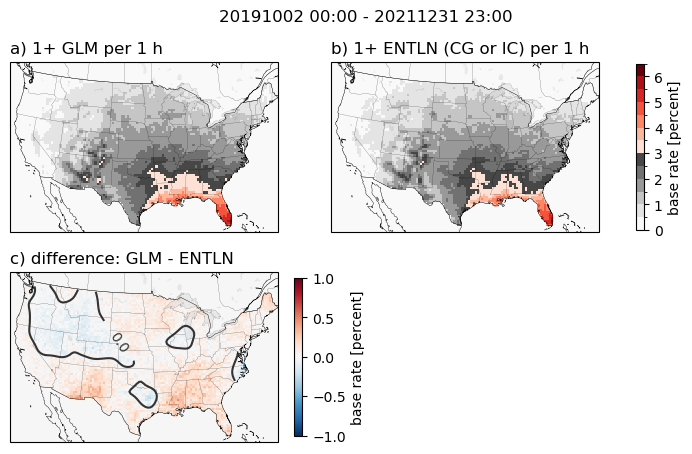

In [17]:
norm = BoundaryNorm(np.arange(0, 7.0, 0.5), ncolors=cmap.N, clip=True)
extent = (-121, -72, 23, 50)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9.5, 5), subplot_kw={"projection": map_crs})
fig.suptitle(twin_str)
ax = axes[0, 0]
base_rate_glm = (glm_twin.where(G211.x2().mask)[var] >= o_thresh).mean(dim="valid_time")
base_rate_glm.name = "base rate"
base_rate_glm = base_rate_glm.metpy.convert_units("%")
base_rate_glm.plot(
    x="lon",
    y="lat",
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)
ax.set_title(
    f"a) {o_thresh}+ GLM per {twin} h",
    loc="left",
)

ax = axes[0, 1]
base_rate_wb = ((wb_cnt_slice.cg + wb_cnt_slice.ic).where(G211.x2().mask) >= o_thresh).mean(
    dim="valid_time"
)
base_rate_wb.name = "base rate"
base_rate_wb = base_rate_wb.metpy.convert_units("%")
base_rate_wb.plot(
    x="lon",
    y="lat",
    ax=ax,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"ax": axes[0], "shrink": 0.95},
)
ax.set_title(
    f"b) {o_thresh}+ ENTLN (CG or IC) per {twin} h", loc="left")

ax = axes[1, 0]
# assert lon and lat are only slightly different (< 1e-13)
# and assign one to the other
assert np.isclose(base_rate_glm.lon, base_rate_wb.lon).all()
base_rate_glm = base_rate_glm.assign_coords(lon = base_rate_wb["lon"])
assert np.isclose(base_rate_glm.lat, base_rate_wb.lat).all()
base_rate_glm = base_rate_glm.assign_coords(lat = base_rate_wb["lat"])
r = base_rate_glm - base_rate_wb
diff_plot(r, ax=ax)
ax.set_title(f"c) difference: GLM - ENTLN", loc="left")
for ax in axes.ravel():
    ax = ax_features(ax, scale=1.2)
    ax.set_extent(extent)
axes[1,1].set_visible(False)

ofile = tmpdir / f"{o_thresh}+{var}.GLM-WxBug.png"
fig.savefig(ofile, dpi=dpi)
logging.warning(ofile)

2024-04-18 09:15:09,181 /glade/derecho/scratch/ahijevyc/tmp/1+flashes_20km_1hr.GLM-WxBugratio.png


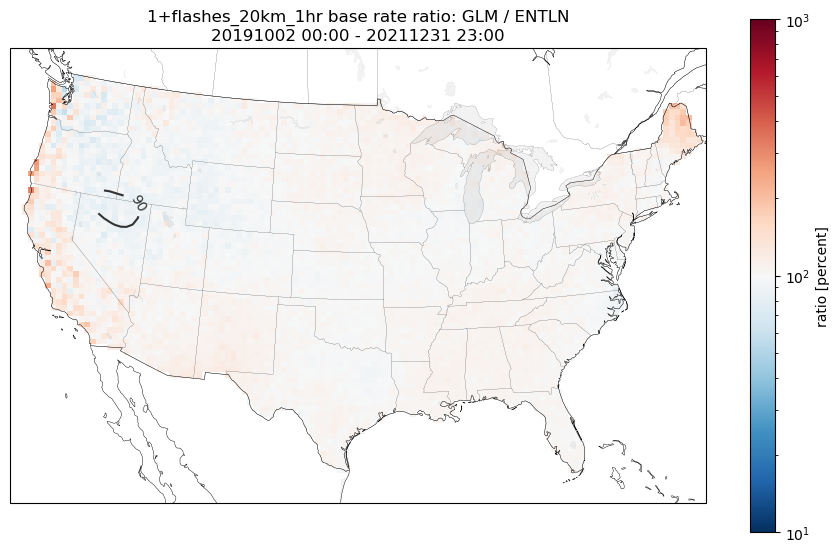

In [18]:
r = base_rate_glm / base_rate_wb
r.name = "ratio"
ax = ratio_plot(r)
ax.set_title(f"{o_thresh}+{var} base rate ratio: GLM / ENTLN\n{twin_str}")
ofile = tmpdir / f"{o_thresh}+{var}.GLM-WxBugratio.png"
plt.tight_layout()
ax.figure.savefig(ofile, dpi=dpi)
logging.warning(ofile)